# Protein Folding Algorithm

Protein folding is the descriptions of a three-dimensional structure of amino-acids chain, arranged in space to become the biologically functional protein.
Understanding the structure of protein is highly valuable for various application within medicine.
While so, discovering the structure of proteins is an highly intricate problem, as each protein is constructed of a chain of hundreds to thousands amino acids, and the number of configurations is roughly evaluated to be $3^{2(N-1)}$ with N the number of amino acid [1]. The exponential growth of conformations with the chain length N makes the problem very complex for classical computers. For a quantum computer, we algorithm which grows linearly with the number of amino acids N were conceived, as the one simulated hereby.

In this demo, we present a method of achieving a folding geometry for a given amino acid sequence. Following paper [2], we create a Pyomo optimization model, and send it to Classiq's Quantum approximated optimization algorithm (QAOA) which finds the configuration with the minimal energy. The results are later visualized and compared to a classical solution.

## 0. Pre-requirments

The model is using several Classiq's libraries in addition to basic python tools.

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pyomo.core as pyo
from sympy import *

## 1. Define the Optimization Problem

Follow the paper [2] we created a python pyomo model to describe an optimization problem where a pramatrized cost expression characterise the geometrical configuration of a protein (amino acid sequence).

Without too many details, the paper places the protein on a grid of tetrahedral lattice. Each amino acid can be located in any vertex of the lattice, and an index is set to each amino acid. Since each vertex has four neighbours, after locating an index in space, the next location will be set by pointing one of the four directions indicated by an integer $[0,1,2,3]$. In order to do ascribe a direction, we assign each amino acid 2 qubits, thus mapping each index to a direction:
$[00] \rightarrow 0$ ;
$[01] \rightarrow 1$ ;
$[10] \rightarrow 2$ ;
$[11] \rightarrow 3$ .
For convenance of the coding, each even and odd index of amino acid, has an opposite meaning in space. I.e., "0" will mean "left" for odd index, but "right" for even index.

For Protein of $N$ amino acids, we have $N-1$ directions (or edges). However, since the first two direction only set the orientation of the molecule in space, but do not determine the relative location of the amino acids, we are left with $N-3$ directions (since in thethrader lattice, there is an equal angle between each three vertices, the relations will be the same for the first three regardless of the chosen direction). Thus, the needed number of qubits to describe the directions in the lattice  is $2(N-3)$, and the two first directions are set arbitrarily.

Next, we need to set the Hamiltonian, i.e. the cost function that will be sent to minimization. The Hamiltonian consists of two terms: $H_{gc}$ describing geometrical constraints, and $H_{int}$ describing the interactions between the amino acids (the paper also discusses a third, chirality constraint which is only relevant to side chains, which were not considered in the scope of this algorithm):

* $H_{gc}$ - prevents two consecutive direction to fold back. Since we used a convention where odd and even index has an opposite meaning in space, it is sufficient to add large penalty term if two consecutive direction are the same.

* $H_{int}$ - For the interaction, we define extra qubits, which determine if the interaction is "turned on". If so, they add negative (beneficial) energy term $epsilon$, which indicates the interaction between amino acids. $epsilon$ is a nearest neighbor (NN) interaction tern, relevant for distance 1 only, therefore we add a penalty for other distances. Note that currently, we are taking the interaction to be constant value ($epsilon$) regurdless of the type of amino acids interaction. This can be easly modified by insering the Miyazawa & Jernigan table [3].

Since it is trivial that following amino acid in the sequence will be nearest neighbors its irrelevant to calculate the contributing energy from such interaction (it will add a constant number regardless of the qubit’s value). In fact, due to the structure of the tetrahedral lattice, only amino acids further than 5 in the sequence might have non-trivial interaction. Thus, the number of possible interactions (and thus the number of interaction qubits) is (N-5)*(N-4)/2 (calculated via arithmetic progression).

In addition, we prevent folding back into the chain, while encouraging distance 1 interactions, by making sure that the indices following the two interacting amino acids, do not overlaps with the interacting amino acid themselves. In other words,  for NN $(i,j)$,  {i-1,i+1} must be at distance 2 (else, they will be at distance 0, i.e. overlapping). To account for that, a penalty is added to the interaction term.

In [2]:
def folding_hamiltonian(main_chain: str) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("protein_folding")
    N = len(main_chain)  # number of amino acids

    # Calc number of possible interactions:
    Ninteraction = 0
    if N > 5:
        Ninteraction = int((N - 5) * (N - 4) / 2)

    # Define the variables:
    model.f = pyo.Var(range(2 * (N - 3)), domain=pyo.Binary)
    model.interaction = pyo.Var(range(Ninteraction), domain=pyo.Binary)
    f_array = np.array(list(model.f.values()))
    interaction_array = np.array(list(model.interaction.values()))

    # Setting the two locations:
    a = np.array([1, 0, 0, 1])
    full_f_array = np.append(a, f_array)

    # Define Hgc:
    T = lambda i, j: (1 - (full_f_array[2 * i] - full_f_array[2 * j]) ** 2) * (
        1 - (full_f_array[2 * i + 1] - full_f_array[2 * j + 1]) ** 2
    )
    L = 500
    model.Hgc = 0
    for i in range(N - 2):
        model.Hgc = model.Hgc + L * T(
            i, i + 1
        )  # adds panelty if two consecutive index has the opposite direction

    # convert {0,1}^2 to 4 functions, each giving 1 for one vector and 0 for the others:
    fun0 = lambda i, j: (1 - full_f_array[i]) * (1 - full_f_array[j])
    fun1 = lambda i, j: full_f_array[i] * (1 - full_f_array[j])
    fun2 = lambda i, j: full_f_array[j] * (1 - full_f_array[i])
    fun3 = lambda i, j: full_f_array[i] * full_f_array[j]

    # calculate distance between i,j amino acids:
    d_units_0 = lambda i, j: sum(
        [((-1) ** k) * fun0(2 * k, 2 * k + 1) for k in range(i, j, 1)]
    )
    d_units_1 = lambda i, j: sum(
        [((-1) ** k) * fun1(2 * k, 2 * k + 1) for k in range(i, j, 1)]
    )
    d_units_2 = lambda i, j: sum(
        [((-1) ** k) * fun2(2 * k, 2 * k + 1) for k in range(i, j, 1)]
    )
    d_units_3 = lambda i, j: sum(
        [((-1) ** k) * fun3(2 * k, 2 * k + 1) for k in range(i, j, 1)]
    )
    d = lambda i, j: (
        (d_units_0(i, j)) ** 2
        + (d_units_1(i, j)) ** 2
        + (d_units_2(i, j)) ** 2
        + (d_units_3(i, j)) ** 2
    )

    # define Hint:
    epsilon = -5000
    L2 = 300
    L1 = 500
    h = lambda i, j: interaction_array[
        sum([N - 5 - k for k in range(0, i + 1, 1)]) - (N - j)
    ] * (
        epsilon
        + L1 * (d(i, j) - 1) ** 2
        + L2
        * (
            (2 - d(j - 1, i)) ** 2
            + (2 - d(j + 1, i)) ** 2
            + (2 - d(i - 1, j)) ** 2
            + (2 - d(i + 1, j)) ** 2
        )
    )
    model.Hint = 0
    for i in range(N - 5):
        j = i + 5
        while j < N:
            model.Hint = model.Hint + h(i, j)
            j = j + 1

    # setting the objective:
    model.cost = pyo.Objective(expr=model.Hint + model.Hgc, sense=pyo.minimize)

    return model

## 2. Create your Protein Sequance
The user defines the amino acid sequance as a string, which is sent to the `folding_hamiltonian()` function in order to create an optimization model for the sequance.

In [3]:
my_protein = "ABCDEF"  # ABCDEFG"
protein_model = folding_hamiltonian(my_protein)

## 3. Optimize Using to Quantum Optimization Algorithm

We will now create a QAOA model for the optimization problem. The results of the model is the sequance of qubit values giving the minimized energy for the protein. In order to optimize the results, we recommend the user to explore the number of repatitions for the model (`num_layers`) and the number of iterations for the optimizer (`max_iteration`).

In [4]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=5)

optimizer_config = OptimizerConfig(
    max_iteration=100,
    alpha_cvar=0.7,
)

qmod = construct_combinatorial_optimization_model(
    pyo_model=protein_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [5]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [6]:
from classiq import write_qmod

write_qmod(qmod, "protein_folding")

Now we can create a quantum circuit using the `synthesize` command and show it

In [7]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/d58ad171-85c6-497d-ab70-c435d8725820?version=0.38.0.dev42%2Bfd36e2c41c


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [8]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

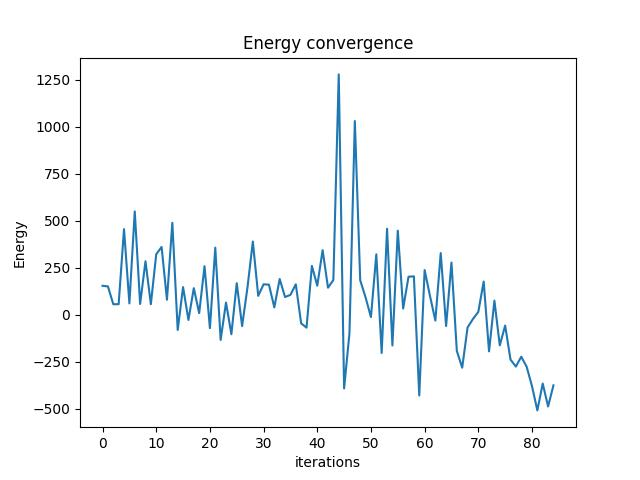

In [9]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

## 4. Present Quantum Results

We hereby present the optimization results. Since this is a quantum solution with probablistic results, there is a defined probability to each results (presented by an histogram), where the solution is chosen to be the most probable one. Below, we translate the solution in terms of qubits, to location in space of the amino acids, thus creating a sketch of the protein folding for the sequence.

In [10]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    protein_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
0,0.084,-2600.0,"[0, 0, 1, 0, 0, 1, 1]",84
1,0.061,-2600.0,"[1, 1, 1, 0, 0, 1, 1]",61
47,0.007,-900.0,"[0, 0, 0, 0, 0, 1, 1]",7
97,0.001,-900.0,"[0, 1, 1, 0, 0, 1, 1]",1
6,0.022,-900.0,"[0, 1, 1, 0, 1, 1, 1]",22


array([[<Axes: title={'center': 'cost'}>]], dtype=object)

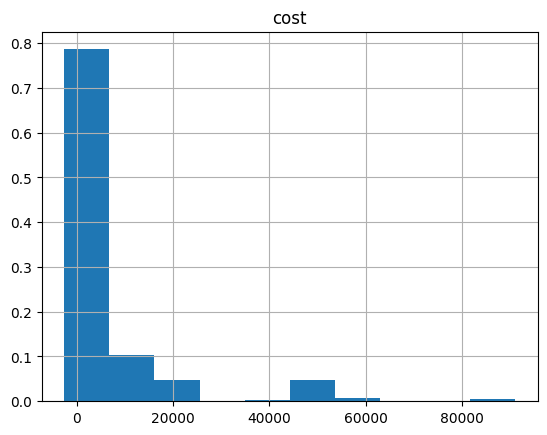

In [11]:
optimization_result.hist("cost", weights=optimization_result["probability"])

In [12]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]

a = np.array([1, 0, 0, 1])
N = len(my_protein)
R = np.append(a, list(best_solution[0 : 2 * (N - 3)]))

x = [0]
y = [0]
z = [0]
for i in range(N - 1):
    if (1 - R[2 * i]) * (1 - R[2 * i + 1]) == 1:
        x.append(x[i] + (-1) ** (i + 1))
        y.append(y[i] + (-1) ** (i))
        z.append(z[i] + (-1) ** (i + 1))
    if R[2 * i] * (1 - R[2 * i + 1]) == 1:
        x.append(x[i] + (-1) ** (i + 1))
        y.append(y[i] + (-1) ** (i + 1))
        z.append(z[i] + (-1) ** (i))
    if R[2 * i + 1] * (1 - R[2 * i]) == 1:
        x.append(x[i] + (-1) ** (i))
        y.append(y[i] + (-1) ** (i + 1))
        z.append(z[i] + (-1) ** (i + 1))
    if R[2 * i] * R[2 * i + 1] == 1:
        x.append(x[i] + (-1) ** (i))
        y.append(y[i] + (-1) ** (i))
        z.append(z[i] + (-1) ** (i))

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z)])
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
fig.show()

## 5. Compare to Classical Results
This section solves the optimization model for the defined amino squance by classical optimization, and presents the results, in order to compare to our QAOA performance. Mismatch of the classical and quantum solution might indicate the need to tune the QAOA parameters.

In [13]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(protein_model)

protein_model.display()

Model protein_folding

  Variables:
    f : Size=6, Index=f_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :     1 : False : False : Binary
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   1.0 :     1 : False : False : Binary
          3 :     0 :   0.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : False : Binary
          5 :     0 :   1.0 :     1 : False : False : Binary
    interaction : Size=1, Index=interaction_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   1.0 :     1 : False : False : Binary

  Objectives:
    cost : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : -2600.0

  Constraints:
    None


In [14]:
best_classical_solution = [pyo.value(protein_model.f[i]) for i in range(2 * (N - 3))]

a = np.array([1, 0, 0, 1])
N = len(my_protein)
R_c = np.append(a, best_classical_solution)

x = [0]
y = [0]
z = [0]
for i in range(N - 1):
    if (1 - R_c[2 * i]) * (1 - R_c[2 * i + 1]) == 1:
        x.append(x[i] + (-1) ** (i + 1))
        y.append(y[i] + (-1) ** (i))
        z.append(z[i] + (-1) ** (i + 1))
    if R_c[2 * i] * (1 - R_c[2 * i + 1]) == 1:
        x.append(x[i] + (-1) ** (i + 1))
        y.append(y[i] + (-1) ** (i + 1))
        z.append(z[i] + (-1) ** (i))
    if R_c[2 * i + 1] * (1 - R_c[2 * i]) == 1:
        x.append(x[i] + (-1) ** (i))
        y.append(y[i] + (-1) ** (i + 1))
        z.append(z[i] + (-1) ** (i + 1))
    if R_c[2 * i] * R_c[2 * i + 1] == 1:
        x.append(x[i] + (-1) ** (i))
        y.append(y[i] + (-1) ** (i))
        z.append(z[i] + (-1) ** (i))

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z)])
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
fig.show()

## References
[1] Levinthal's paradox https://en.wikipedia.org/wiki/Levinthal%27s_paradox

[2] Robert, Anton, Panagiotis Kl Barkoutsos, Stefan Woerner, and Ivano Tavernelli. "Resource-efficient quantum algorithm for protein folding." npj Quantum Information 7, no. 1 (2021): 1-5.

[3] Miyazawa, S. & Jernigan, R. L. Residue-residue potentials with a favorable contact
pair term and an unfavorable high packing density term, for simulation and
threading. J. Mol. Biol. 256, 623–644 (1996).
